In [1]:
from glob import glob
import sys, scipy
from scipy.stats import chi2, poisson
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

from prettytable import PrettyTable

In [2]:
import ROOT as rt
import root_numpy as rtnp
from utility_func import *

Welcome to JupyROOT 6.10/08


/Users/olmo/programs/root-6.10.08/lib/ROOT.py:318: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return _orig_ihook( name, *args, **kwds )
Using TensorFlow backend.


In [3]:
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import layers as KL
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
import keras
print keras.__version__

2.1.2


In [4]:
do_training = 0

# Get the samples

In [5]:
hlf_features = ['HT', 'METp', 'METo', 'MT', 'nJets', 
                'bJets', 'allJetMass', 'LepPt', 'LepEta', 
                'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu', 'LepCharge', 
                'LepIsEle', 'nMu', 'allMuMass', 'allMuPt', 'nEle', 
                'allEleMass', 'allElePt', 'nChHad', 'nNeuHad', 'nPhoton']

active_hlf_features = ['HT', 'allJetMass',
                       'allMuPt', 'allMuMass',
                       'allElePt','allEleMass',
                       'LepPt', 'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu',
                       
                       'LepEta', 'METp', 'METo',
                       
                       'MT',
                       
                       'nMu', 'nJets', 'bJets', 'nEle', 
                       
                       'LepCharge','LepIsEle', 
                       
                       'nChHad', 'nNeuHad']

Nf_lognorm = 10
Nf_gauss = 3
Nf_Pgauss = 1
Nf_PDgauss = 4
Nf_binomial = 2
Nf_poisson = 2

sel = []
for a in active_hlf_features:
    for i,f in enumerate(hlf_features):
        if a == f:
            sel.append(i)
# print 'Activated HLF:'
# for n in np.array(hlf_features)[sel]:
#     print '\t', n

In [6]:
data_folder = '../../data/HLF_ONLY/'
TrainSamplesName = ['Wlnu', 'qcd', 'ttbar']
BSM_samples = ['Ato4l', 'Zprime', 'Wprime', 'leptoquark']

N_train_max = int(2e6)

In [7]:
trigger_rate = np.array([440., 251., 2.51])
fraction = trigger_rate/ np.sum(trigger_rate)

raw_sample = {}
l = np.zeros(3)
for i,n in enumerate(TrainSamplesName):
    raw_sample[n] = np.load(data_folder+n+'_lepFilter_13TeV_sample.npy')
    l[i] = raw_sample[n].shape[0]
    
i_min = np.argmin(l/fraction)
print 'Limiting stat. sample:', TrainSamplesName[i_min]

N_train = min(0.8*l[i_min], N_train_max)

x_train_s = {}
x_val_s = {}

table = PrettyTable(['Sample', 'Evts tot', 'Train', 'Val'])

for i,n in enumerate(TrainSamplesName):
    N_train_aux = int(N_train * fraction[i]/fraction[i_min])
    x_train_s[n] = raw_sample[n][:N_train_aux, sel]
    x_val_s[n] = raw_sample[n][N_train_aux : int(N_train_aux*1.2) - 1, sel]
    table.add_row([n, raw_sample[n].shape[0], N_train_aux, x_val_s[n].shape[0]])
print table
    
x_train = np.concatenate((x_train_s['Wlnu'], x_train_s['qcd'], x_train_s['ttbar']))
x_val = np.concatenate((x_val_s['Wlnu'], x_val_s['qcd'], x_val_s['ttbar']))

Limiting stat. sample: qcd
+--------+----------+---------+--------+
| Sample | Evts tot |  Train  |  Val   |
+--------+----------+---------+--------+
|  Wlnu  | 5003421  | 1635460 | 327091 |
|  qcd   | 1166195  |  932956 | 186590 |
| ttbar  | 5001726  |   9329  |  1864  |
+--------+----------+---------+--------+


# Start the VAE declaration

In [8]:
original_dim = x_train.shape[1]
latent_dim = 4
intermediate_dim = 50
act_fun = 'relu'

In [9]:
x_DNN_input = Input(shape=(original_dim,))
hidden_1 = Dense(intermediate_dim, activation=act_fun)(x_DNN_input)
hidden_2 = Dense(intermediate_dim, activation=act_fun)(hidden_1)
# hidden_3 = Dense(intermediate_dim, activation=act_fun)(hidden_2)

L_z_mean = Dense(latent_dim)(hidden_2)

L_z_sigma_preActivation = Dense(latent_dim)(hidden_2)
L_z_sigma = Lambda(InverseSquareRootLinearUnit)(L_z_sigma_preActivation)

In [10]:
L_z_latent_DNN = Lambda(sampling)([L_z_mean, L_z_sigma])
decoder_h1 = Dense(intermediate_dim, activation=act_fun)(L_z_latent_DNN)
decoder_h2 = Dense(intermediate_dim, activation=act_fun)(decoder_h1)
# decoder_h3 = Dense(intermediate_dim, activation=act_fun)(decoder_h2)
L_par1 = Dense(original_dim)(decoder_h2)

L_par2_preActivation = Dense(Nf_lognorm + Nf_gauss + Nf_Pgauss + Nf_PDgauss)(decoder_h2)
L_par2 = Lambda(InverseSquareRootLinearUnit)(L_par2_preActivation)

L_par3_preActivation = Dense(Nf_lognorm)(decoder_h2)
L_par3 = Lambda(ClippedTanh)(L_par3_preActivation)

Create Prior Layer

In [11]:
fixed_input = Lambda(SmashTo0)(x_DNN_input)
h1_prior = Dense(20, kernel_initializer='zeros', bias_initializer='ones', trainable=False)(fixed_input)
# h2_prior = Dense(100, activation=act_fun)(h1_prior)

L_prior_mean = Dense(latent_dim, kernel_initializer='zeros', bias_initializer='zeros', trainable=True)(h1_prior)

L_prior_sigma_preActivation = Dense(latent_dim, kernel_initializer='zeros', bias_initializer='ones', trainable=True)(h1_prior)
L_prior_sigma = Lambda(InverseSquareRootLinearUnit)(L_prior_sigma_preActivation)

Custom loss function

In [12]:
def KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior):
    kl_loss = K.tf.multiply(K.square(sigma), K.square(sigma_prior))
    kl_loss += K.square(K.tf.divide(mu_prior - mu, sigma_prior))
    kl_loss += K.log(K.tf.divide(sigma_prior, sigma)) -1
    return K.mean(0.5 * K.sum(kl_loss, axis=-1))

def RecoProb_forVAE(x, par1, par2, par3):
    N = 0
    nll_loss = 0
    
    #Log-Normal distributed variables
    mu = par1[:,:Nf_lognorm]
    sigma = par2[:,:Nf_lognorm]
    fraction = par3[:,:Nf_lognorm]
    x_clipped = K.clip(x[:,:Nf_lognorm], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,:Nf_lognorm], clip_x_to0), 
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma) 
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma))
                           )
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_lognorm
    
    # Gaussian distributed variables
    mu = par1[:,N:N+Nf_gauss]
    sigma = par2[:,N:N+Nf_gauss]
    norm_x = K.tf.divide(x[:,N:N+Nf_gauss] - mu, sigma)
    single_NLL = K.log(sigma) + 0.5*K.square(norm_x)
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_gauss
    
    # Positive Gaussian distributed variables
    mu = par1[:,N:N+Nf_Pgauss]
    sigma = par2[:,N:N+Nf_Pgauss]
    norm_x = K.tf.divide(x[:,N:N+Nf_Pgauss] - mu, sigma)

    sqrt2 = 1.4142135624
    aNorm = 1 + 0.5*(1 + K.tf.erf(K.tf.divide(- mu, sigma)/sqrt2))
    
    single_NLL = K.log(sigma) + 0.5*K.square(norm_x) - K.log(aNorm)
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_Pgauss
    
    # Positive Discrete Gaussian distributed variables
    mu = par1[:,N:N+Nf_PDgauss]
    sigma = par2[:,N:N+Nf_PDgauss]
    norm_xp = K.tf.divide(x[:,N:N+Nf_PDgauss] + 0.5 - mu, sigma)
    norm_xm = K.tf.divide(x[:,N:N+Nf_PDgauss] - 0.5 - mu, sigma)
    sqrt2 = 1.4142135624
    single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))
    
    norm_0 = K.tf.divide(-0.5 - mu, sigma)
    aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
    
    single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_PDgauss
    
    #Binomial distributed variables
    p = 0.5*(1+0.98*K.tanh(par1[:, N: N+Nf_binomial]))
    single_NLL = -K.tf.where(K.equal(x[:, N: N+Nf_binomial],1), K.log(p), K.log(1-p))
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_binomial
    
    #Poisson distributed variables
    aux = par1[:, N:]
    mu = 1 + K.tf.where(K.tf.greater(aux, 0), aux, K.tf.divide(aux, K.sqrt(1+K.square(aux))))
    single_NLL = K.tf.lgamma(x[:, N:]+1) - x[:, N:]*K.log(mu) + mu
    nll_loss += K.sum(single_NLL, axis=-1)
    
    return K.mean(nll_loss)

def LossVAE(y_train, NETout):
    mu = NETout[:, :latent_dim]
    N = latent_dim
    
    sigma = NETout[:, N: N+latent_dim]
    N += latent_dim
    
    mu_prior = NETout[:, N: N+latent_dim]
    N += latent_dim
    
    sigma_prior = NETout[:, N: N+latent_dim]
    N += latent_dim
    
    par1 = NETout[:, N: N+original_dim]
    N += original_dim
    
    par2 = NETout[:, N: N+Nf_lognorm+Nf_gauss+Nf_Pgauss+Nf_PDgauss]
    N += Nf_lognorm+Nf_gauss+Nf_Pgauss+Nf_PDgauss
    
    par3 = NETout[:, N:N+Nf_lognorm]
    
    return KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior) + RecoProb_forVAE(y_train[:, :original_dim], par1, par2, par3)

In [13]:
def RecoProb_metric(y_train, NETout):
    N = 4*latent_dim
    
    par1 = NETout[:, N: N+original_dim]
    N += original_dim
    
    par2 = NETout[:, N: N+Nf_lognorm+Nf_gauss+Nf_Pgauss+Nf_PDgauss]
    N += Nf_lognorm+Nf_gauss+Nf_Pgauss+Nf_PDgauss
    
    par3 = NETout[:, N:N+Nf_lognorm]
    
    return RecoProb_forVAE(y_train[:, :original_dim], par1, par2, par3)

def KL_loss_metric(y_train, NETout):
    mu = NETout[:, :latent_dim]
    sigma = NETout[:, latent_dim: 2*latent_dim]
    mu_prior = NETout[:, 2*latent_dim: 3*latent_dim]
    sigma_prior = NETout[:, 3*latent_dim: 4*latent_dim]
    return KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior)

In [14]:
global_outputs = KL.concatenate([L_z_mean, L_z_sigma, L_prior_mean, L_prior_sigma, L_par1, L_par2, L_par3], axis=1)

vae = Model(inputs=x_DNN_input, outputs=global_outputs)
vae.compile(optimizer='adam', loss=LossVAE, metrics=[RecoProb_metric, KL_loss_metric])
print vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 22)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           1150        input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 50)           2550        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 4)            204         dense_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (D

# Training

In [15]:
y_train = np.concatenate((x_train, np.zeros((x_train.shape[0], 66 - x_train.shape[1]))), axis=1)

In [16]:
if do_training:
    fit_report = vae.fit(x=x_train, y=y_train,
            validation_data = (x_val, x_val),
            shuffle=True,
            epochs=200,
            batch_size=400,
            callbacks = [
                            EarlyStopping(monitor='val_loss', patience=10l, verbose=1, min_delta=0.05),
                            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, epsilon=0.1, verbose=1),
                            TerminateOnNaN()
                ])

In [17]:
if do_training:
    f = plt.figure(figsize=(16,8))
    style = {'loss':'--', 'RecoProb_metric': 'o', 'KL_loss_metric': '--'}
    for item in ['loss', 'RecoProb_metric', 'KL_loss_metric']:
        plt.plot(np.array(fit_report.history[item][:])[1:], style[item], label=item)
        plt.plot(np.array(fit_report.history['val_'+item][:])[1:], style[item], label='val_'+item)

    plt.xlabel('Epoch')
    plt.grid()
    plt.legend(loc='best')

In [18]:
if do_training:
    vae.save('VAE_all-in-one_v3.1.h5')
else:
    from keras.models import load_model
    custom_objects = {
        'original_dim': x_train.shape[1],
        'latent_dim': latent_dim,
        'intermediate_dim': intermediate_dim,
        'act_fun': act_fun,
        'Nf_lognorm' : Nf_lognorm,
        'Nf_gauss' : Nf_gauss,
        'Nf_Pgauss' : Nf_Pgauss,
        'Nf_PDgauss' : Nf_PDgauss,
        'Nf_binomial' : Nf_binomial,
        'Nf_poisson' : Nf_poisson,
        'LossVAE': LossVAE,
        'RecoProb_metric': RecoProb_metric,
        'KL_loss_metric': KL_loss_metric    
    }
    
    vae = load_model('VAE_all-in-one_v3.1.h5', custom_objects=custom_objects)
    print 'Loaded'

Loaded


2018-10-10 19:01:46.881777: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.2 AVX AVX2 FMA


### Build encoder and decoder

Get prior means and variance array

In [19]:
if do_training:
    Prior_Dumper = Model(inputs=x_DNN_input, outputs=[L_prior_mean, L_prior_sigma])
    Prior_Dumper.save('prior_all-in-one_v3.1.h5')
else:
    Prior_Dumper = load_model('prior_all-in-one_v3.1.h5', custom_objects=custom_objects)
    
aux = Prior_Dumper.predict(np.zeros((1, original_dim)))
mu_prior = aux[0][0]
sigma_prior = aux[1][0]

print mu_prior
print sigma_prior

[1.8949570e-03 1.7915239e+00 7.0193887e+00 1.8044628e+00]
[1.5441611 1.3777955 3.26373   1.3476117]


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [20]:
if do_training:
    encoder = Model(inputs=x_DNN_input, outputs=[L_z_mean, L_z_sigma])
    encoder.save('encoder_all-in-one_v3.1.h5')
else:
    encoder = load_model('encoder_all-in-one_v3.1.h5', custom_objects=custom_objects)

# Validation

Gather the signal data

In [21]:
x_sig = {}
for n in BSM_samples+TrainSamplesName:
    s = np.load(data_folder+n+'_lepFilter_13TeV_sample.npy')
    x_sig[n] = s[:N_train_max, sel]

### Predict latent space

In [22]:
x_train_encoded = np.array(encoder.predict(x_train))

x_sig_encoded = {}
for k,v in x_sig.iteritems():
    print k
    x_sig_encoded[k] = np.array(encoder.predict(v))

Ato4l
Wlnu
Wprime
qcd
leptoquark
Zprime
ttbar


Latent space mean distribution

In [23]:
# def sum_of_gaussians(x, mu_vec, sigma_vec):
#     x = np.atleast_2d(x)
#     if x.shape[0] <= x.shape[1]:
#         x = x.T
#     x_norm = (x - mu_vec)/sigma_vec
#     single_gaus_val = np.exp(-0.5*np.square(x_norm))/(sigma_vec*np.sqrt(2*np.pi))
#     return np.sum(single_gaus_val, axis=1)/mu_vec.shape[0]

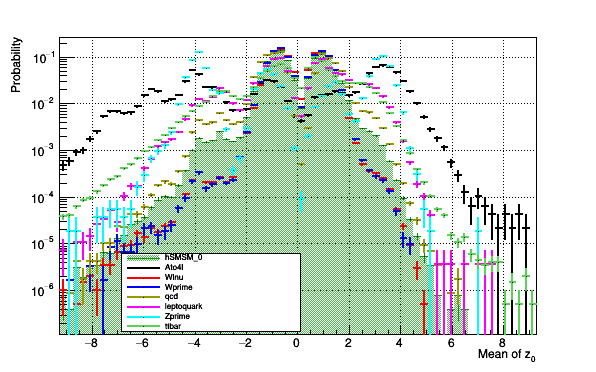

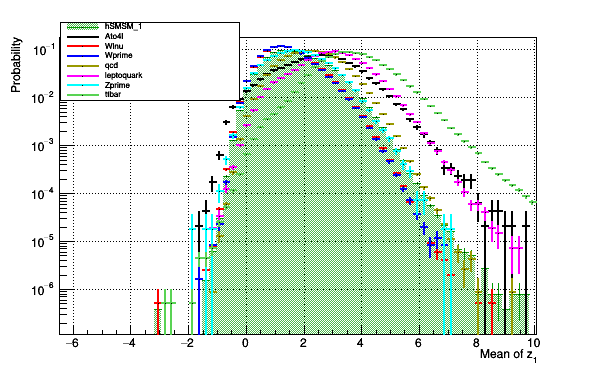

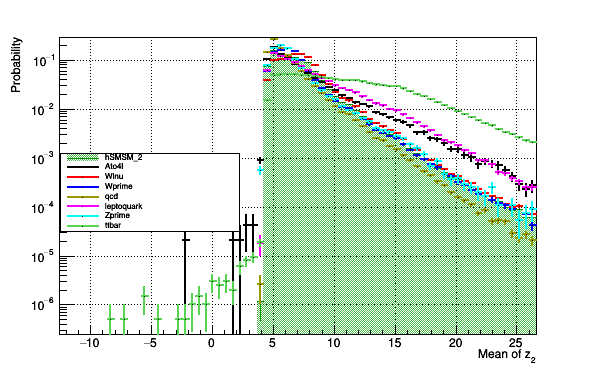

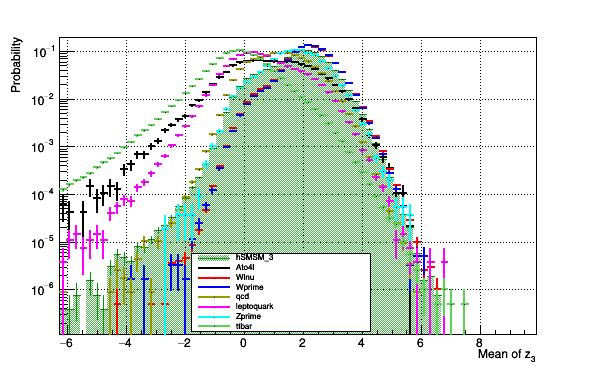

In [24]:
histos = []
canvases = []
binning = [70, -8, 8]

SampleName = 'SM'

for kk in range(latent_dim):
    c = rt.TCanvas('c'+str(kk), 'c'+str(kk), 600, 400)

    lower_bound = mu_prior[kk] - 6*sigma_prior[kk]
    upper_bound = mu_prior[kk] + 6*sigma_prior[kk]
    h = rt.TH1F('hSM{}_{}'.format(SampleName, kk), SampleName, binning[0], lower_bound, upper_bound)
    z = x_train_encoded[0, :, kk]
    rtnp.fill_hist(h, z, weights=1/float(z.shape[0])*np.ones_like(z))
    h.SetStats(0)
    h.SetLineColor(rt.kGreen+4-2)
    h.SetFillColorAlpha(rt.kGreen+4-2, 0.7)
    h.SetFillStyle(3001)
    
    h.SetTitle('')
    h.SetXTitle('Mean of z_{'+str(kk)+'}')
    h.SetYTitle('Probability')
    
    h.Draw('Bar SAME')
    histos.append(h)


    colors = [1,2,4,rt.kYellow+2,6,7,8,46, 30, 40]
    # fill
    for i, n in enumerate(x_sig.keys()):
        h = rt.TH1F('hBSM{}_{}'.format(i, kk), n, binning[0], lower_bound, upper_bound)
        z = x_sig_encoded[n][0, :, kk]
        rtnp.fill_hist(h, z, weights=1/float(z.shape[0])*np.ones_like(z))

        h.SetStats(0)
        h.SetLineColor(colors[i])
        h.SetLineWidth(2)
        h.Draw('SAME')
        histos.append(h)

    c.BuildLegend()
    c.SetGrid()
    c.SetLogy()
    c.Draw()
    canvases.append(c)
    
fout = rt.TFile('plots/all-in-one_v3-1_meanZ.root', 'RECREATE')
for obj in canvases + histos:
    obj.Write()

fout.Close()

## Recostruction sum of pdf

In [25]:
if do_training:
    autoencoder = Model(inputs=x_DNN_input, outputs=[L_par1, L_par2, L_par3])
    autoencoder.save('autoencoder_all-in-one_v3.1.h5')
else:
    autoencoder = load_model('autoencoder_all-in-one_v3.1.h5', custom_objects=custom_objects)

In [26]:
pars_ae_train = autoencoder.predict(x_train)
# print pars_ae_train.shape

pars_ae_sig = {}
for k,v in x_sig.iteritems():
    print k
    pars_ae_sig[k] = autoencoder.predict(v)

Ato4l
Wlnu
Wprime
qcd
leptoquark
Zprime
ttbar


HT
allJetMass
allMuPt
allMuMass
allElePt
allEleMass
LepPt
LepIsoCh
LepIsoGamma
LepIsoNeu
LepEta
METp
METo
MT
nMu
nJets
bJets
nEle
LepCharge
LepIsEle
nChHad
nNeuHad


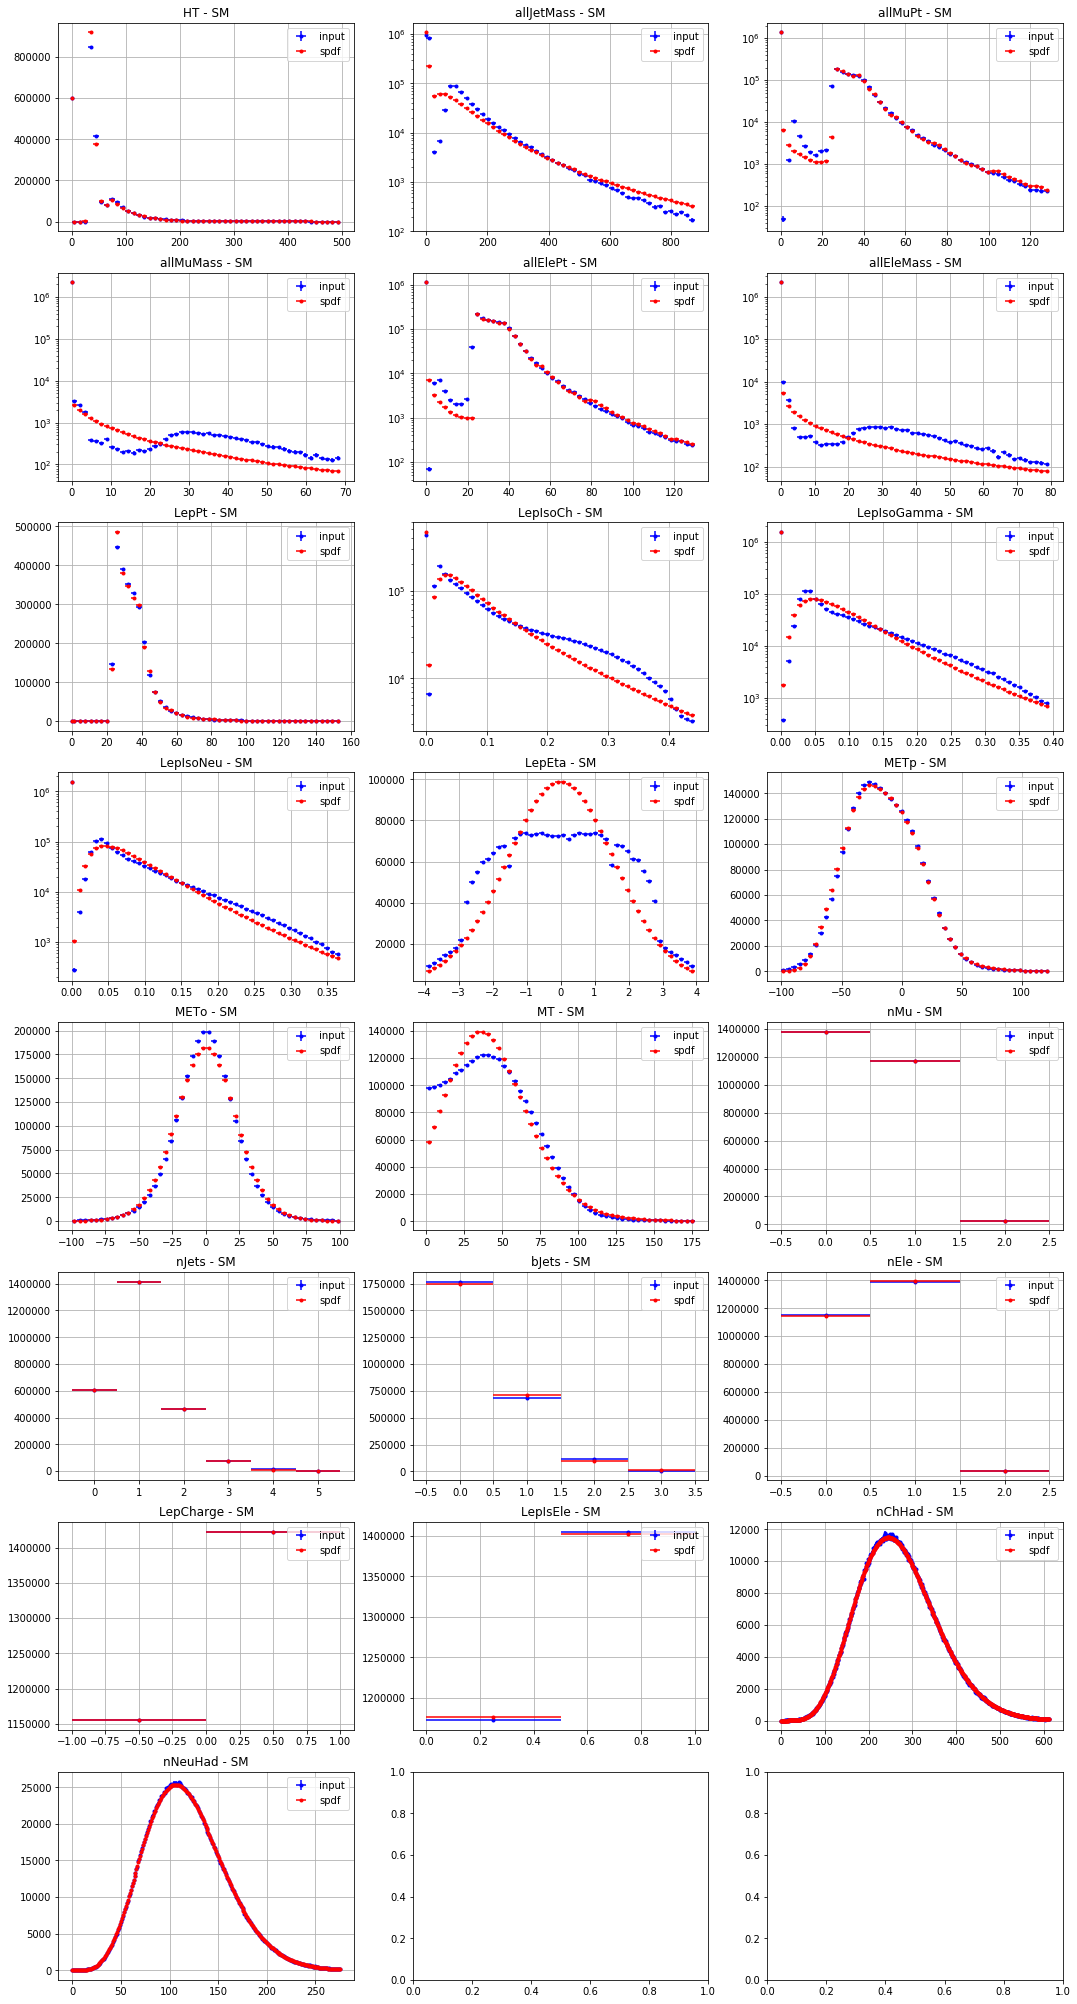

In [27]:
f, ax_arr = plt.subplots(1+int(len(active_hlf_features)/3.),3 , figsize=(18,36))
N_bins = 50
for i,hlf_name in enumerate(active_hlf_features):
    print hlf_name
#     plt.yscale('log', nonposy='clip')
    
    #Plot distribution of the variable
    x_aux = x_train[:, i]
    if i < Nf_lognorm:
        histo_range = (0, np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=N_bins, range=histo_range)
        if np.sum(bin_edges>clip_x_to0) > 0:
            i_aux = np.argmin(bin_edges<clip_x_to0)
            bin_edges = np.concatenate((np.array([0, clip_x_to0]), bin_edges[i_aux:]))
        else:
            bin_edges = np.array([0, clip_x_to0])
        bin_content, bin_edges = np.histogram(x_aux, bins=bin_edges, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bin_edges[1:] - bin_edges[:-1]
        bin_width[0] = 1.

        mu_vec = pars_ae_train[0][:, i]
        sigma_vec = pars_ae_train[1][:, i]
        f_vec = pars_ae_train[2][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_lognorm(bincenters, f_vec, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss:
        histo_range = (np.percentile(x_aux, .1), np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=N_bins, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_train[0][:, i]
        sigma_vec = pars_ae_train[1][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_gaussians(bincenters, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss + Nf_Pgauss:
        histo_range = (np.percentile(x_aux, .1), np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=N_bins, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_train[0][:, i]
        sigma_vec = pars_ae_train[1][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_Pgauss(bincenters, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss + Nf_Pgauss + Nf_PDgauss:
        Nmax = int(np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=Nmax+1, range=(-0.5, Nmax+0.5))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_train[0][:, i]
        sigma_vec = pars_ae_train[1][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_PDgauss(bincenters, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss + Nf_Pgauss + Nf_PDgauss + Nf_binomial:
        bin_content, bin_edges = np.histogram(x_aux, bins=2, range=(np.min(x_aux), np.max(x_aux)))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]
        p = 0.5*(1+0.98*np.tanh(pars_ae_train[0][:, i]))

        spdf_bin_content = np.zeros_like(bincenters)
        spdf_bin_content[np.nonzero(bin_content)[0][1]] = np.sum(p)
        spdf_bin_content[np.nonzero(bin_content)[0][0]] = np.sum(1-p)
    else:
        Nmax = int(np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=Nmax+1, range=(-0.5, Nmax+0.5))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]
        aux = pars_ae_train[0][:, i]
        mu_vec = 1 + np.where(np.greater(aux, 0), aux, np.divide(aux, np.sqrt(1+np.square(aux))))
        spdf_bin_content = sum_of_possion(bincenters, mu_vec)


    if i < Nf_lognorm:
        bin_width[0] = clip_x_to0
        
    ax_arr[i/3, i%3].errorbar(bincenters, bin_content, xerr=bin_width/2., yerr=np.sqrt(bin_content), fmt='.b', label='input')
    ax_arr[i/3, i%3].errorbar(bincenters, spdf_bin_content, xerr=bin_width/2., fmt='.r', label='spdf')
    ax_arr[i/3, i%3].grid()
    ax_arr[i/3, i%3].set_title(hlf_name + ' - ' + SampleName)        
    ax_arr[i/3, i%3].legend(loc='best')
    
    if hlf_name.startswith('LepIso') or hlf_name.startswith('all'):
        ax_arr[i/3, i%3].set_yscale('log')
        
plt.show()

# Test Statistics with Losses

In [27]:
from scipy.special import loggamma

In [28]:
def numpy_KL_loss(mu, sigma):
    sp = np.atleast_2d(sigma_prior)
    mp = np.atleast_2d(mu_prior)
    kl_loss = np.square(sigma)*np.square(sp)
    kl_loss += np.square((mp - mu)/sp)
    kl_loss += np.log(sp/sigma) -1

    return 0.5 * np.sum(kl_loss, axis=-1)

def numpy_RecoProb(x, par1, par2, par3):
    N = 0
    nll_loss = 0
    
    #Log-Normal distributed variables
    mu = par1[:,:Nf_lognorm]
    sigma = par2[:,:Nf_lognorm]
    fraction = par3[:,:Nf_lognorm]
    x_clipped = np.clip(x[:,:Nf_lognorm], clip_x_to0, 1e8)
    single_NLL = np.where(np.less(x[:,:Nf_lognorm], clip_x_to0), 
                            -np.log(fraction),
                                -np.log(1-fraction)
                                + np.log(sigma) 
                                + np.log(x_clipped)
                                + 0.5*np.square((np.log(x_clipped) - mu) / sigma)
                           )
    nll_loss += np.sum(single_NLL, axis=-1)
    N += Nf_lognorm
    
    # Gaussian distributed variables
    mu = par1[:,N:N+Nf_gauss]
    sigma = par2[:,N:N+Nf_gauss]
    norm_x = (x[:,N:N+Nf_gauss] - mu)/sigma
    single_NLL = np.log(sigma) + 0.5*np.square(norm_x)
    nll_loss += np.sum(single_NLL, axis=-1)
    N += Nf_gauss
    
    # Positive Gaussian distributed variables
    mu = par1[:,N:N+Nf_Pgauss]
    sigma = par2[:,N:N+Nf_Pgauss]
    norm_x = (x[:,N:N+Nf_Pgauss] - mu)/sigma

    sqrt2 = 1.4142135624
    aNorm = 1 + 0.5*(1 + erf( -mu/(sigma*sqrt2) ))
    
    single_NLL = np.log(sigma) + 0.5*np.square(norm_x) - np.log(aNorm)
    nll_loss += np.sum(single_NLL, axis=-1)
    N += Nf_Pgauss
    
    # Positive Discrete Gaussian distributed variables
    mu = par1[:,N:N+Nf_PDgauss]
    sigma = par2[:,N:N+Nf_PDgauss]
    norm_xp = (x[:,N:N+Nf_PDgauss] + 0.5 - mu)/sigma
    norm_xm = (x[:,N:N+Nf_PDgauss] - 0.5 - mu)/sigma
    sqrt2 = 1.4142135624
    single_LL = 0.5*(erf(norm_xp/sqrt2) - erf(norm_xm/sqrt2))
    
    norm_0 = (-0.5 - mu)/sigma
    aNorm = 1 + 0.5*(1 + erf(norm_0/sqrt2))
    
    single_NLL = -np.log(np.clip(single_LL, 1e-10, 1e40)) -np.log(aNorm)
    nll_loss += np.sum(single_NLL, axis=-1)
    N += Nf_PDgauss
    
    #Binomial distributed variables
    p = 0.5*(1+0.98*np.tanh(par1[:, N: N+Nf_binomial]))
    single_NLL = -np.where(np.equal(x[:, N: N+Nf_binomial],1), np.log(p), np.log(1-p))
    nll_loss += np.sum(single_NLL, axis=-1)
    N += Nf_binomial
    
    #Poisson distributed variables
    aux = par1[:, N:]
    mu = 1 + np.where(np.greater(aux, 0), aux, aux/np.sqrt(1+np.square(aux)))
    single_NLL = loggamma(x[:, N:]+1).real - x[:, N:]*np.log(mu) + mu
    nll_loss += np.sum(single_NLL, axis=-1)
    
    return nll_loss

def numpy_loss(x, x_encoded, pars_ae):
    mu = x_encoded[0]
    sigma = x_encoded[1]    
    kl_loss = numpy_KL_loss(mu, sigma)
    
    nll_loss = numpy_RecoProb(x, pars_ae[0], pars_ae[1], pars_ae[2])
    
    return np.array([nll_loss + kl_loss, nll_loss, kl_loss])

In [29]:
loss_train = numpy_loss(x_train, x_train_encoded, pars_ae_train)

loss_sig = {}
for n in x_sig.keys():
    print n
    loss_sig[n] = numpy_loss(x_sig[n], x_sig_encoded[n], pars_ae_sig[n])

Ato4l
Wlnu
Wprime
qcd
leptoquark
Zprime
ttbar


828.7431944529734
821.7419385444565
127.17857915997757


Warning in <TROOT::Append>: Replacing existing TH1: h_loss_BSM6_2 (Potential memory leak).


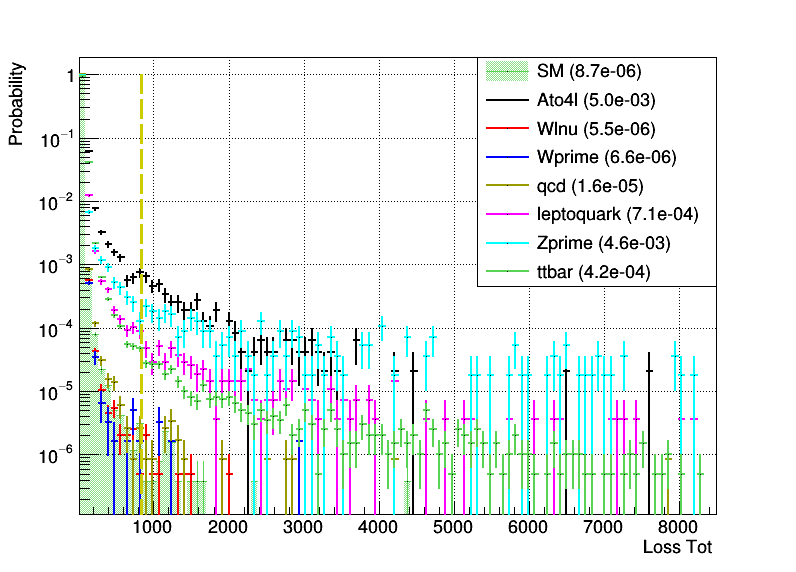

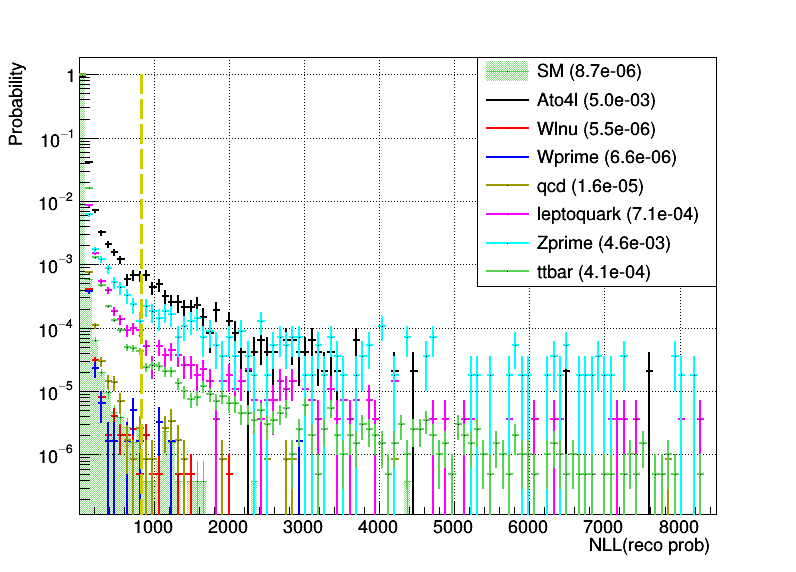

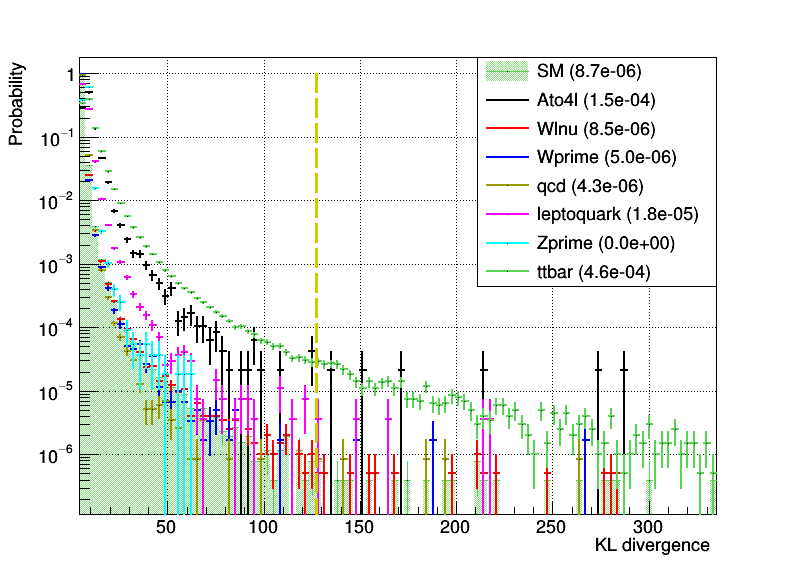

In [37]:
histos = []
canvases = []
Ytitles = ['Loss Tot', 'NLL(reco prob)', 'KL divergence']

for loss_piece in range(3):
    binning = [100, np.min(loss_train[loss_piece]), np.max(loss_train[loss_piece])]
    c = rt.TCanvas('c'+str(loss_piece), 'c'+str(loss_piece), 800, 600)


    h = rt.TH1F('h_loss_SM{}_{}'.format('all-in-one', loss_piece), SampleName, binning[0], binning[1], binning[2])
    rtnp.fill_hist(h, loss_train[loss_piece])
    h.Scale(1./loss_train[loss_piece].shape[0])

    h.SetStats(0)
    h.SetLineColor(8)
    h.SetFillColorAlpha(8, 0.7)
    h.SetFillStyle(3001)
    h.Draw('Bar SAME')
    histos.append(h)

    val_to_cut = np.percentile(loss_train[loss_piece], 100*(1-8.65e-06))
    h.SetTitle(h.GetTitle()+' ({:1.1e})'.format(8.65e-06))
    print val_to_cut





    colors = [1,2,4,rt.kYellow+2,6,7,8,46, 30, 40]
    # fill
    for i, n in enumerate(x_sig.keys()):
        z = loss_sig[n][loss_piece]
        eff = np.sum(z>val_to_cut)/float(z.shape[0])
#         print n, ': {:1.2e}'.format(eff)
        h1 = rt.TH1F('h_loss_BSM{}_{}'.format(i, loss_piece), n+' ({:1.1e})'.format(eff), binning[0], binning[1], binning[2])
        rtnp.fill_hist(h1, z)
        h1.Scale(1./float(z.shape[0]))

        h1.SetStats(0)
        h1.SetLineColor(colors[i])
        h1.SetLineWidth(2)
        h1.Draw('SAME')
        histos.append(h1)

    c.BuildLegend(0.6,0.5,0.9,0.9)
    h.SetTitle('')
    h.SetXTitle(Ytitles[loss_piece])
    h.SetYTitle('Probability')

    line = rt.TLine()
    line.SetLineColor(rt.kYellow+1)
    line.SetLineWidth(3)
    line.SetLineStyle(9)
    line.DrawLine(val_to_cut,0, val_to_cut,1)

    c.SetGrid()
    c.SetLogy()
    c.Draw()
    canvases.append(c)
    
fout = rt.TFile('plots/'+SampleName+ '_v3-1_SWAN_losses.root', 'RECREATE')
for obj in canvases + histos:
    obj.Write()

fout.Close()



In [31]:
import h5py

fout = h5py.File('losses/all-in-one_v3.1.h5', "w")
fout.create_dataset('SM_train_mixture', data=np.array(loss_train))
for k,v in loss_sig.items():
    fout.create_dataset(k, data=np.array(v))
fout.close()

In [43]:
cuts_on_loss = [828, 821, 127]
trigger_rate_dic = {'Wlnu':440. ,'qcd':251., 'ttbar':2.5} #Hz
acquisition_sec_per_year = 1e7
lumi_per_yr = 50 #fb^-1

for ll, cut in enumerate(cuts_on_loss):
    print '----------------',Ytitles[ll], '----------------'
    table_SM = PrettyTable(['Sample', 'Efficiency','Rate [mHz]', 'evts/month'])
    table_BSM = PrettyTable(['Sample', 'Efficiency', 'xsec 100 evts/m [fb]', 'xsec S/B=0.3 [fb]'])
    
    N_tot = 0
    d_N_tot2 = 0
    
    for n, lss in loss_sig.items():
        aux = np.greater(lss[ll,:], cut)
        selected = np.sum(aux)
        eff = float(selected)/lss.shape[1]
        d_eff = np.sqrt(eff*(1-eff)/lss.shape[1])
        
        if n in ['qcd', 'Wlnu', 'ttbar']:
            rate = trigger_rate_dic[n]*eff
            N_evts = rate*acquisition_sec_per_year/12.
            N_tot += N_evts
            d_N_evts = trigger_rate_dic[n]*d_eff*acquisition_sec_per_year/12.
            d_N_tot2 += np.square(d_N_evts)
            table_SM.add_row([n, '{:1.1e} +/- {:1.1e}'.format(eff, d_eff), '{:.1f}'.format(1000*rate), '{:.0f} +/- {:.0f}'.format(N_evts, d_N_evts)])
        else:
            if eff == 0:
                x_sec_lim = -1
                x_sec_SoB = -1
            else:
                x_sec_lim = 100. * 12/ (lumi_per_yr * eff)
                x_sec_SoB = 0.3*N_tot*12/ (lumi_per_yr * eff)
            table_BSM.add_row([n, '{:1.1e} +/- {:1.0e}'.format(eff, d_eff), '{:.1f}'.format(x_sec_lim), '{:1.1e}'.format(x_sec_SoB)])


    print table_SM
    print 'Expected evts/m: {:.0f} +/- {:.0f}'.format(N_tot, np.sqrt(d_N_tot2))
    print table_BSM
    print '\n\n'

---------------- Loss Tot ----------------
+--------+---------------------+------------+--------------+
| Sample |      Efficiency     | Rate [mHz] |  evts/month  |
+--------+---------------------+------------+--------------+
|  Wlnu  | 5.5e-06 +/- 1.7e-06 |    2.4     | 2017 +/- 608 |
|  qcd   | 1.6e-05 +/- 3.7e-06 |    4.1     | 3408 +/- 782 |
| ttbar  | 4.2e-04 +/- 1.4e-05 |    1.1     |  876 +/- 30  |
+--------+---------------------+------------+--------------+
Expected evts/m: 6301 +/- 991
+------------+-------------------+----------------------+-------------------+
|   Sample   |     Efficiency    | xsec 100 evts/m [fb] | xsec S/B=0.3 [fb] |
+------------+-------------------+----------------------+-------------------+
|   Ato4l    | 5.0e-03 +/- 3e-04 |        4790.8        |      0.0e+00      |
|   Wprime   | 6.6e-06 +/- 3e-06 |      3633972.0       |      2.2e+07      |
| leptoquark | 7.1e-04 +/- 5e-05 |       34023.3        |      5.5e+05      |
|   Zprime   | 4.6e-03 +/- 3e-04